# Binoculars

In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow
import trieste

from gpflow_sampling.sampling import priors, updates, decoupled
from trieste.objectives import (
    BRANIN_SEARCH_SPACE,
    SCALED_BRANIN_MINIMUM,
    SHEKEL_4_SEARCH_SPACE,
    SHEKEL_4_MINIMUM,
    MICHALEWICZ_2_MINIMUM,
    MICHALEWICZ_2_SEARCH_SPACE,
)

tfd = tfp.distributions
dtype = tf.float64

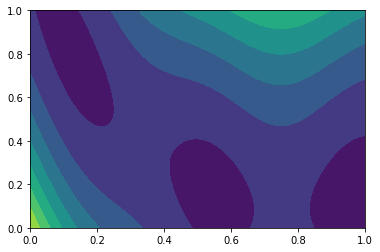

In [2]:
x_plot = tf.meshgrid(tf.linspace(0., 1., 100), tf.linspace(0., 1., 100))
x_plot = tf.stack(x_plot, axis=-1)
x_plot = tf.cast(x_plot, dtype=dtype)

y_plot = trieste.objectives.single_objectives.scaled_branin(x_plot)
y_plot = tf.cast(y_plot, dtype=dtype)

plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], y_plot[:, :, 0])
plt.show()

In [3]:
def stable_logsumexp(x, axis):
    
    xmax = tf.reduce_max(x, axis=axis, keepdims=True)
    xmax_reduced = tf.reduce_max(x, axis=axis)
    diff = x - xmax
    
    return tf.math.reduce_logsumexp(diff, axis=axis) + xmax_reduced

def expected_improvement(
        function_samples,
        batch_x,
        threshold,
        beta=None,
        pointwise=False,
    ):
    
    # Compute noiseless pathwise sample values
    batch_f = function_samples(batch_x)[:, :, 0]
    zeros = tf.zeros_like(batch_f)
    
    if not pointwise:
        
        if beta is None:
            diff_and_zeros = tf.concat([batch_f - threshold, zeros], axis=-1)
            improvement = tf.reduce_min(diff_and_zeros, axis=-1)
            
        else:
            diff_and_zeros = tf.concat([batch_f - threshold, zeros], axis=-1)
            improvement = -beta**-1. * tf.math.reduce_logsumexp(-beta * diff_and_zeros, axis=-1) + np.log(batch_f.shape[0])
    
    else:
        
        if beta is None:
            diff_and_zeros = tf.stack([batch_f - threshold, zeros], axis=-1)
            improvement = tf.reduce_min(diff_and_zeros, axis=-1)
            
        else:
            diff_and_zeros = tf.stack([batch_f - threshold, zeros], axis=-1)
            improvement = -beta**-1. * tf.math.reduce_logsumexp(-beta * diff_and_zeros, axis=-1) + np.log(batch_f.shape[0])
            
    return tf.reduce_mean(improvement, axis=0)


# def compute_optimal_batch(
#         function_samples,
#         threshold,
#         x_min,
#         x_max,
#         num_points,
#         num_steps,
#         learn_rate,
#         seed,
#         beta=None,
#         batch_x=None,
#         print_every=None,
#     ):
            
#     @tf.function
#     def single_step(
#             function_samples,
#             batch_x,
#             threshold,
#             optimiser,
#             beta,
#         ):

#         with tf.GradientTape() as tape:

#             tape.watch(batch_x)

#             loss = expected_improvement(
#                 function_samples=function_samples,
#                 batch_x=batch_x,
#                 threshold=threshold,
#                 beta=beta,
#             )

#         gradients = tape.gradient(loss, [batch_x])
        
#         optimiser.apply_gradients(zip(gradients, [batch_x]))
#         batch_x.assign(tf.clip_by_value(batch_x, x_min, x_max))

#         return loss, gradients
    
#     dim = x_min.shape[0]
#     dtype = x_min.dtype
    
#     u = tf.random.uniform([num_points, dim], dtype=dtype)
    
#     if batch_x is None:
#         batch_x = tf.Variable(u * x_min[None, :] + (1 - u) * x_max[None, :])
        
#     else:
#         batch_x = tf.Variable(batch_x)
    
#     optimiser = tf.optimizers.Adam(learning_rate=learn_rate)
    
#     misc = {
#         "batches": [],
#         "gradients": [],
#     }
#     losses = []
    
#     for i in tf.range(num_steps):
        
#         misc["batches"].append(tf.convert_to_tensor(batch_x))
        
#         loss, gradients = single_step(
#             function_samples=function_samples,
#             batch_x=batch_x,
#             threshold=threshold,
#             optimiser=optimiser,
#             beta=beta,
#         )
        
#         misc["gradients"].append(tf.convert_to_tensor(gradients))
        
#         if tf.reduce_any(tf.math.is_nan(gradients)):
#             print(gradients)
#             raise ValueError
        
#         if tf.reduce_any(tf.math.is_nan(batch_x)):
#             print(batch_x)
#             raise ValueError
        
#         if print_every and i % print_every == 0:
#             tf.print(loss)
            
#         losses.append(loss)
            
#     return batch_x, losses, misc


def compute_optimal_batch_lbfgsb(
        function_samples,
        threshold,
        x_min,
        x_max,
        num_points,
        num_steps,
        learn_rate,
        seed,
        batch_x,
        beta=None,
        print_every=None,
    ):
    
    dim = x_min.shape[0]
    dtype = x_min.dtype
        
    batch_x = tf.Variable(batch_x)
        
    x_min = tf.tile(tf.reshape(x_min, (-1,)), (batch_x.shape[0],))
    x_max = tf.tile(tf.reshape(x_max, (-1,)), (batch_x.shape[0],))
    
    bounds = scp.optimize.Bounds(lb=x_min, ub=x_max)
    history = [batch_x]
    
    class Placeholder(tf.keras.Model):
        
        def __init__(self, variable, name="placeholder", **kwargs):
            super().__init__(name=name, **kwargs)
            self.variable = variable
            
        def loss(self):
            loss = tf.reshape(expected_improvement(
                function_samples=function_samples,
                batch_x=self.variable,
                threshold=threshold,
                beta=beta,
            ), ())
            
            return loss
        
    def callback(x):
        history.append(np.reshape(x, (-1, dim)))
        
    placeholder = Placeholder(variable=batch_x)
    
    result = gpflow.optimizers.Scipy().minimize(
        closure=placeholder.loss,
        variables=placeholder.trainable_variables,
        bounds=bounds,
        callback=callback,
        compile=False,
    )
    
    batch_x = np.reshape(result["x"], (-1, dim))
    history = np.stack(history, axis=0)
                       
    return batch_x, history


def get_query_point(
        function_samples,
        threshold,
        batch_x,
        mode,
        temperature=None,
    ):

    batch_mean, batch_var = gp.predict_f(batch_x)
    
    pointwise_ei = expected_improvement(
        function_samples=function_samples,
        batch_x=batch_x,
        threshold=threshold,
        pointwise=True,
    )
    
    if mode == "best":
        i = tf.argmin(pointwise_ei)
    
    elif mode == "random":
        i = tf.argmin(tf.random.uniform([batch_x.shape[0]]))
    
    elif mode == "tempered":
        
        logits = - tf.reshape(pointwise_ei, (1, -1))
        logit_range = tf.reduce_max(logits) - tf.reduce_min(logits)
        
        logits = logits / ((logit_range + 1e-9) * temperature)
        
        i = tf.random.categorical(
            logits=logits,
            num_samples=1,
        )[0, 0]
    
    else:
        raise ValueError(f"Bad mode {mode}.")
        
    return batch_x[i], pointwise_ei

In [4]:
# tf.random.set_seed(0)

# objective = trieste.objectives.single_objectives.scaled_branin
# f = lambda x: tf.cast(objective(x), dtype=dtype)
# num_queries = 20

# x_min = tf.cast(tf.convert_to_tensor([0., 0.]), dtype=dtype)
# x_max = tf.cast(tf.convert_to_tensor([1., 1.]), dtype=dtype)
# num_initial = 10
# num_ei_samples = 1000
# num_steps = 2000
# learn_rate = 1e-1
# mode = "tempered"
# temperature = 1.

# x_data = tf.cast(
#     tf.random.uniform([num_initial, 2]), 
#     dtype=dtype
# )

# y_data = tf.cast(
#     trieste.objectives.single_objectives.scaled_branin(x_data),
#     dtype=dtype,
# )

# num_samples = 3

# prior_fn = priors.random_fourier(gpflow.kernels.Matern32(), sample_shape=[num_samples], num_bases=1024)
# decoupled_fn = decoupled(gpflow.kernels.Matern32(), prior_fn, x_data, y_data, diag=0.0)
# samples = decoupled_fn(x_plot)

# for i in range(num_samples):
#     plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], samples[i, :, :, 0])
#     plt.show()

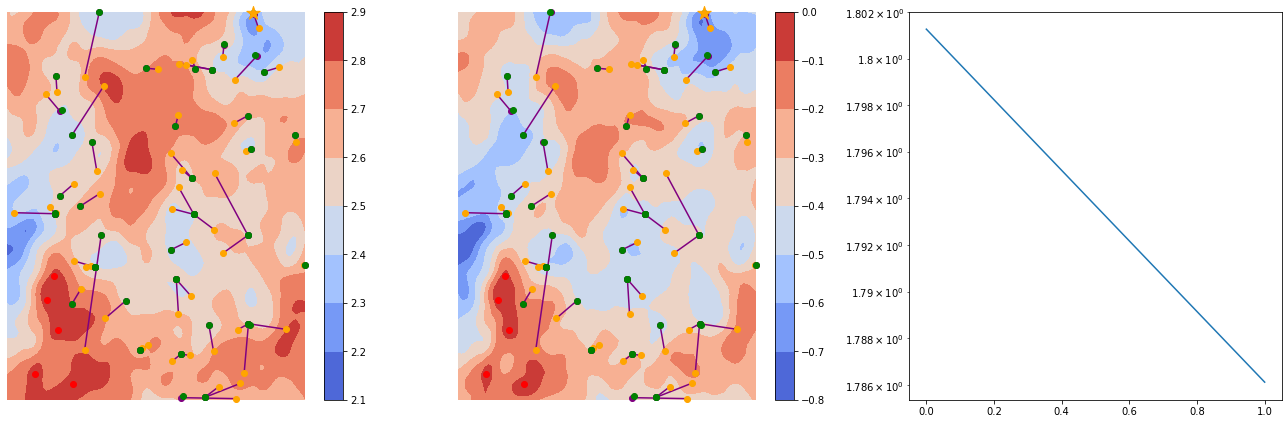

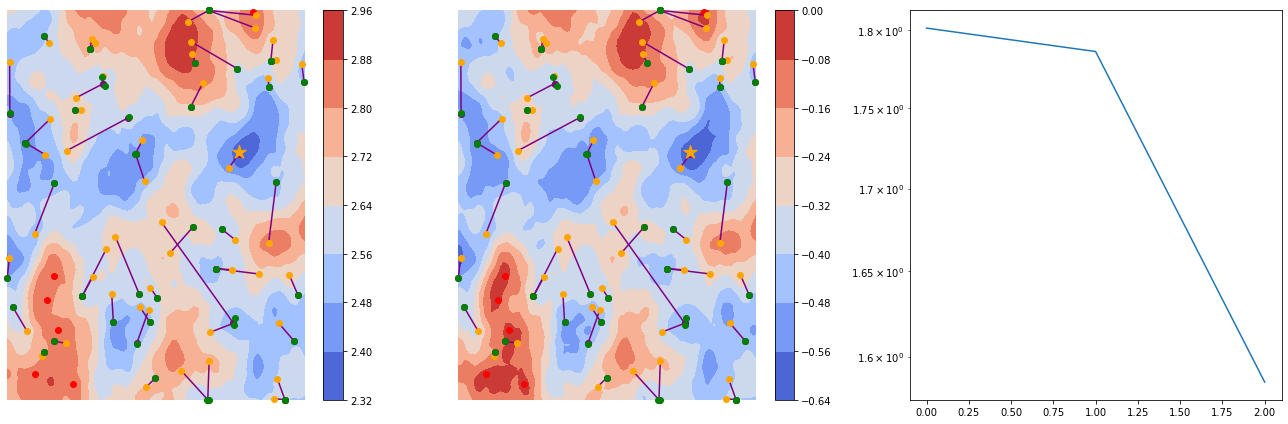

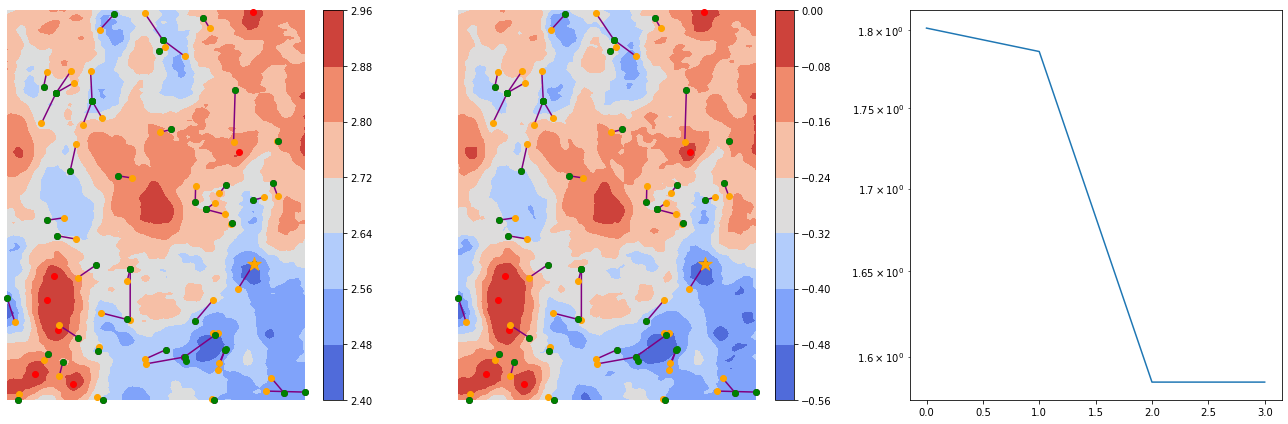

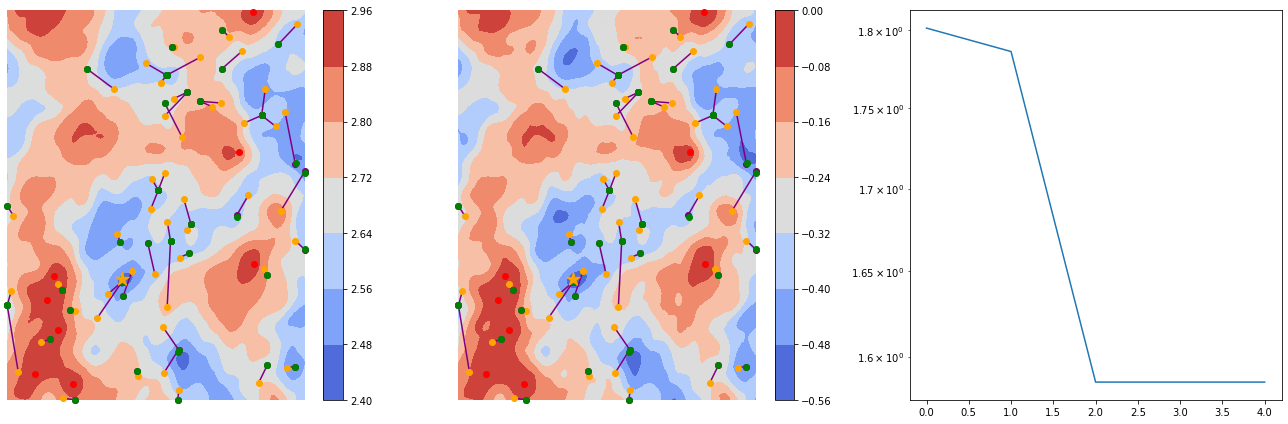

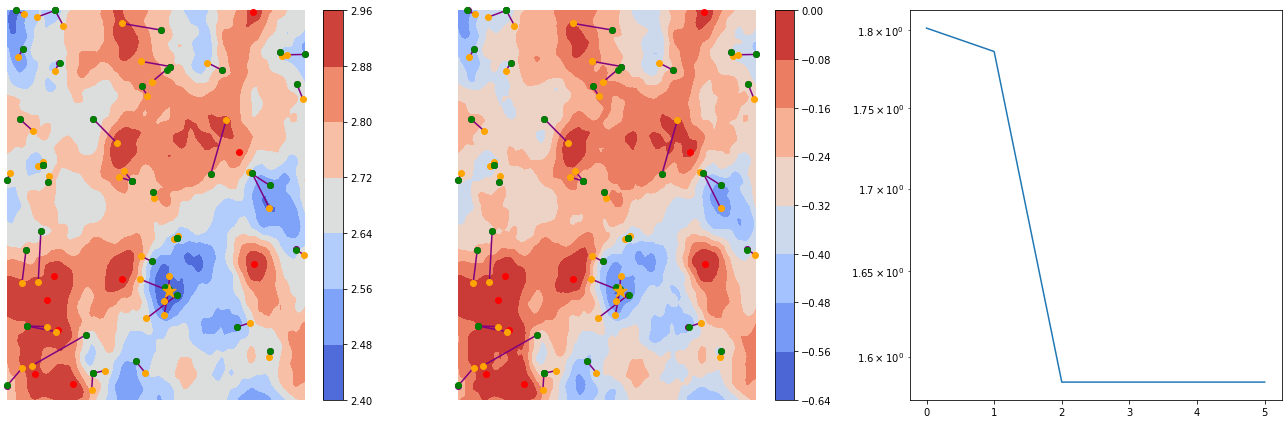

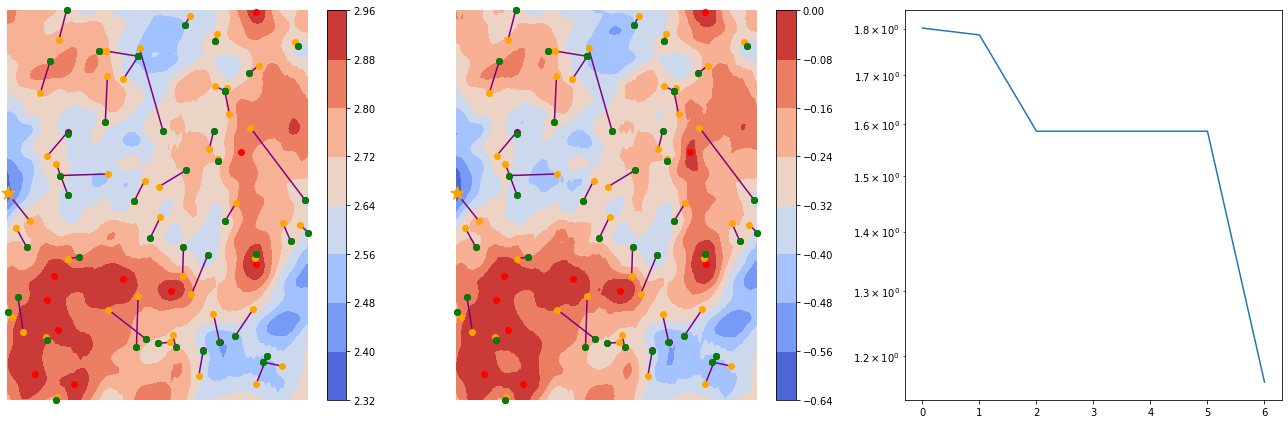

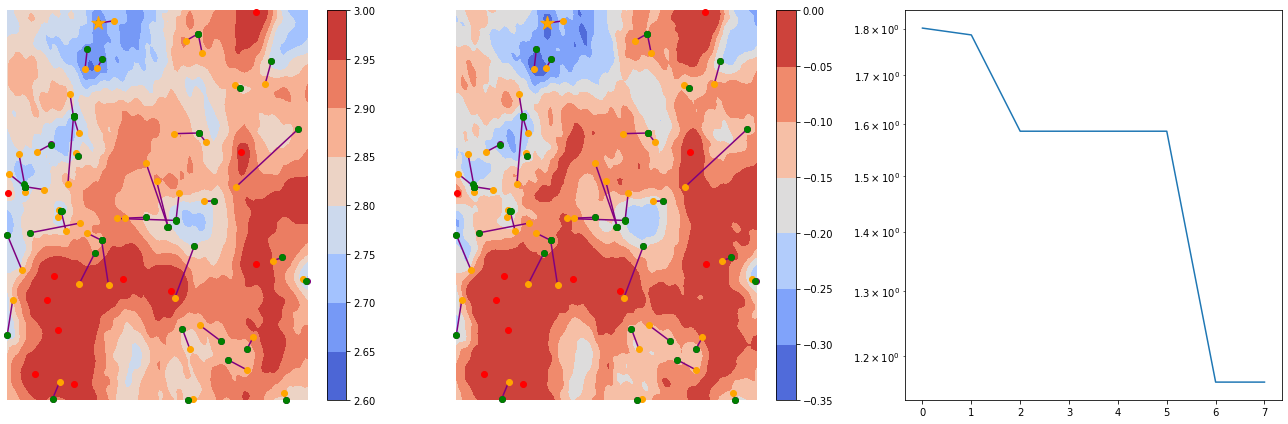

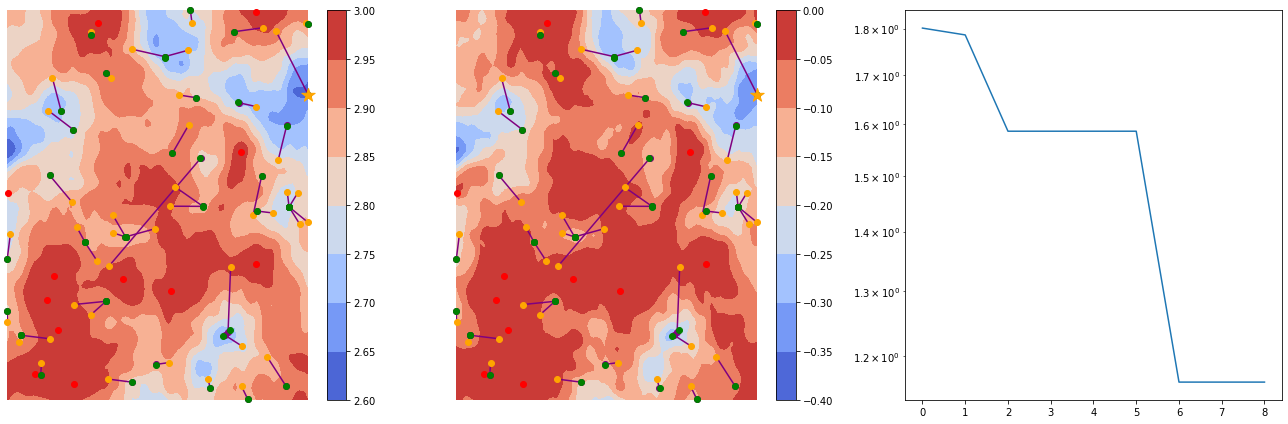

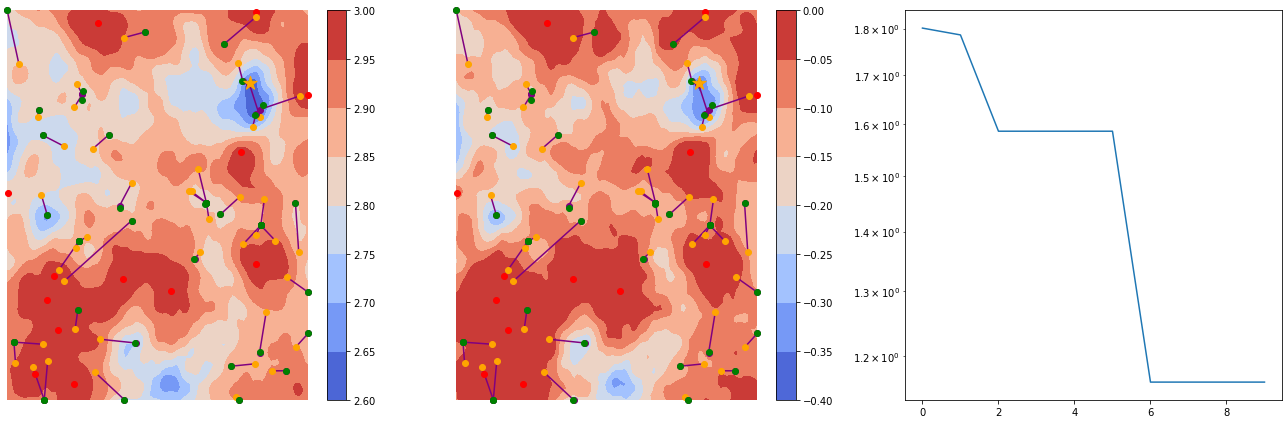

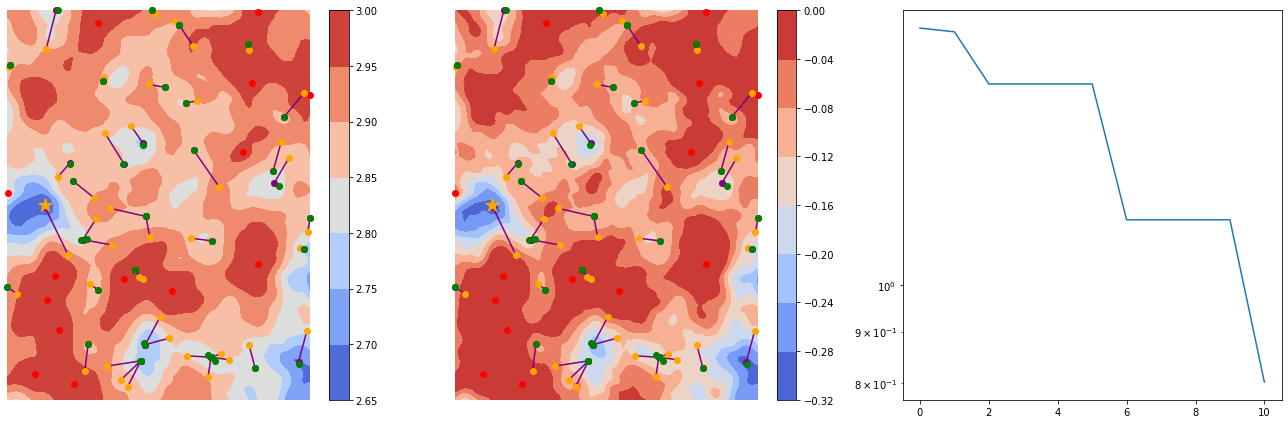

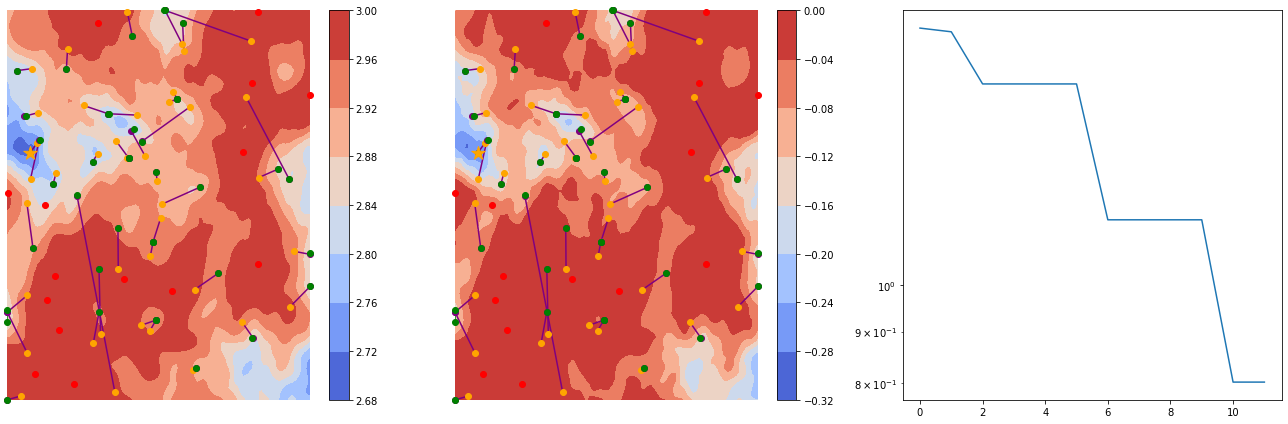

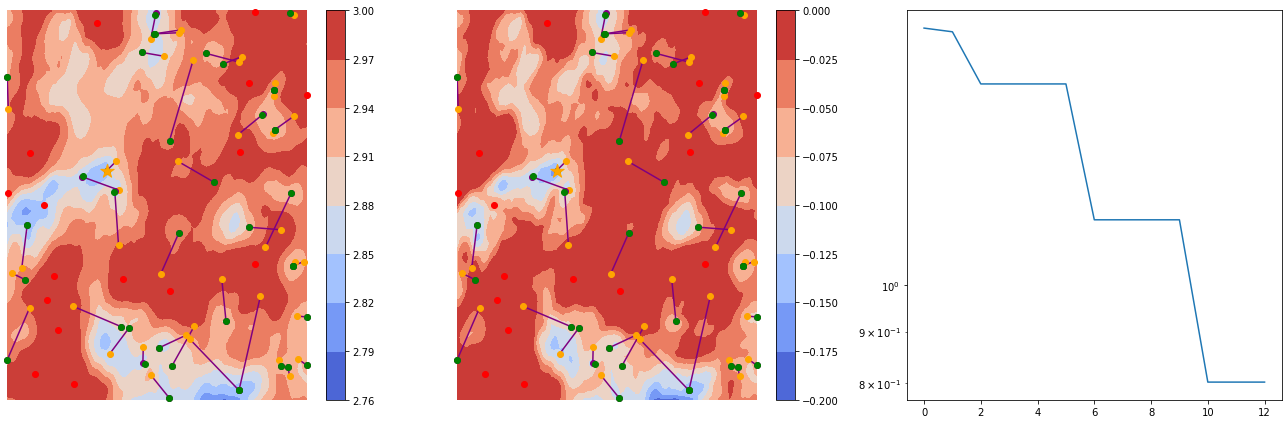

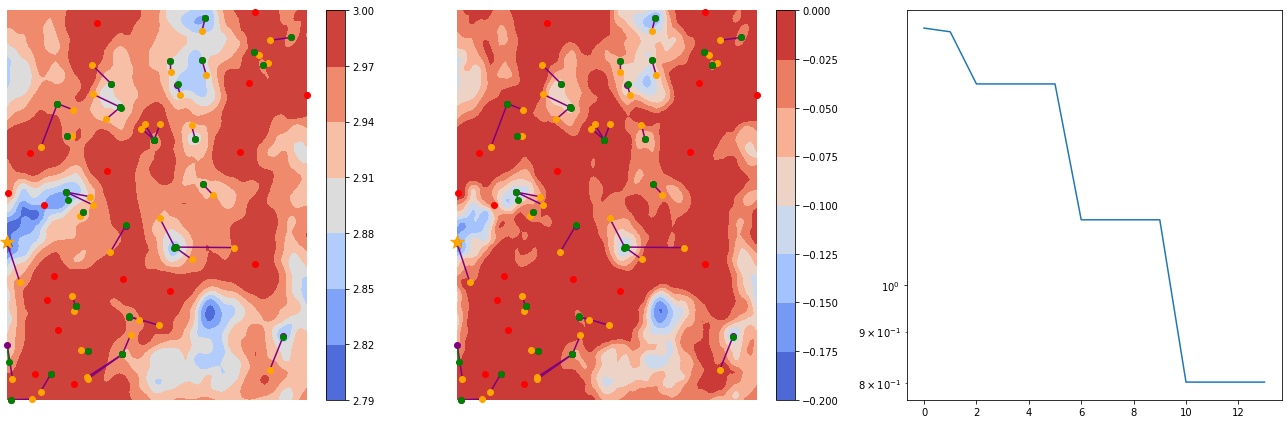

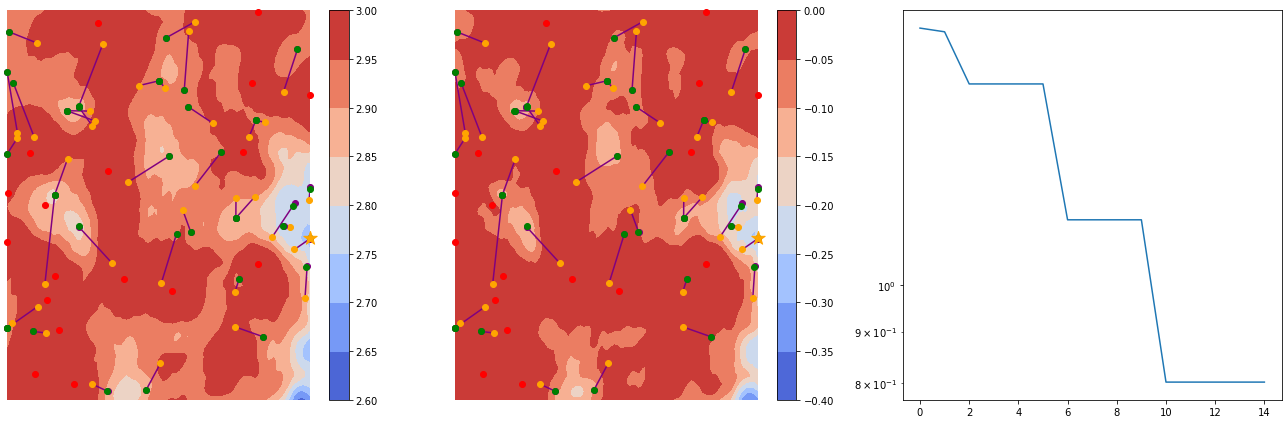

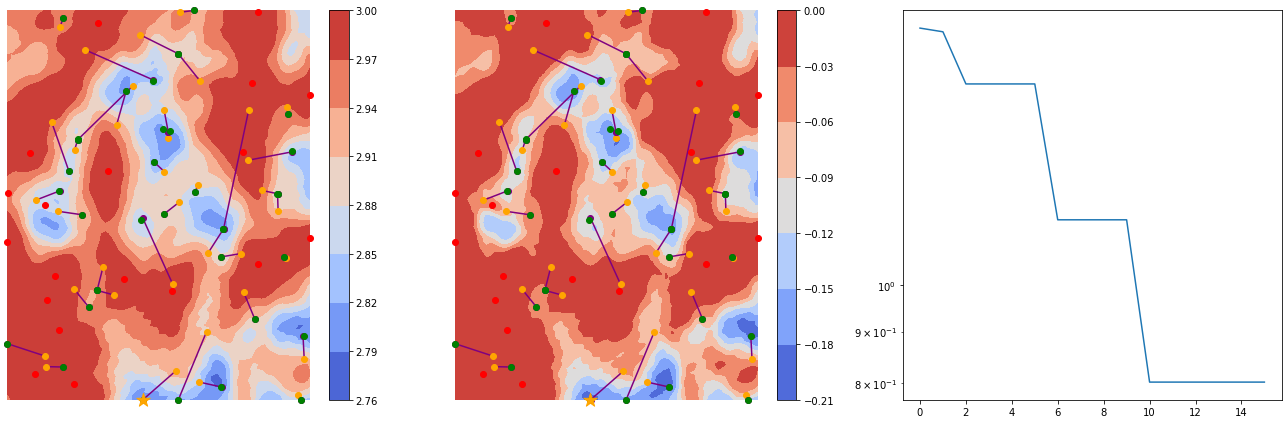

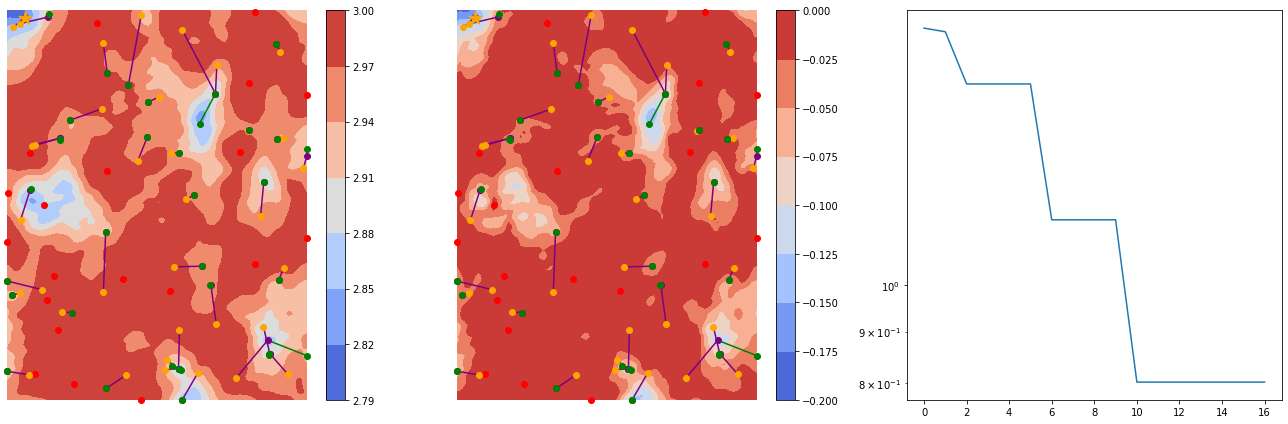

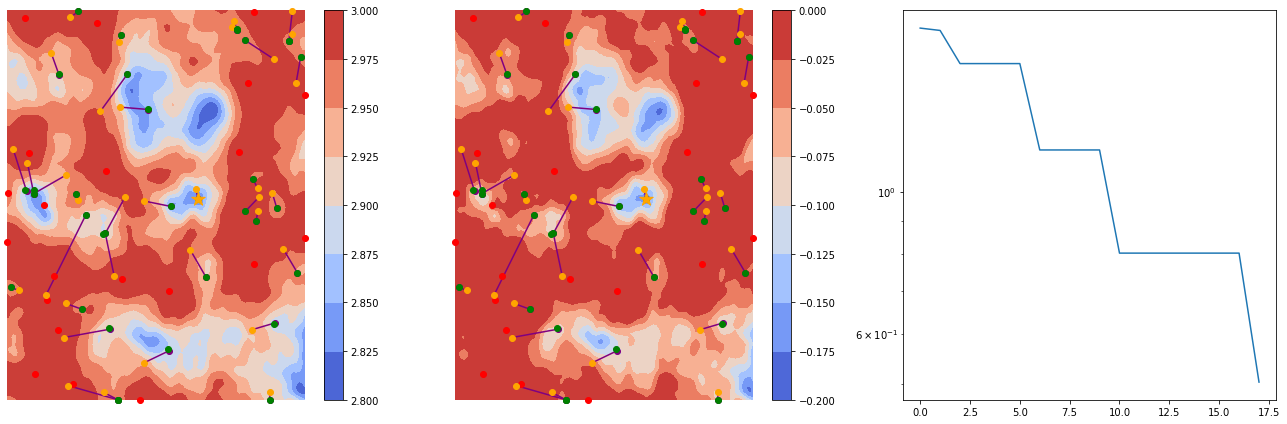

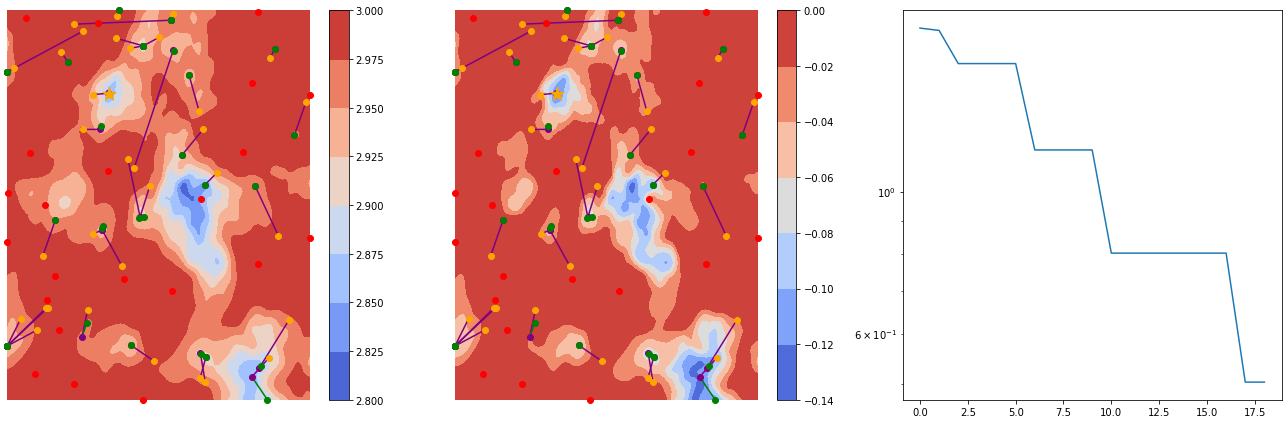

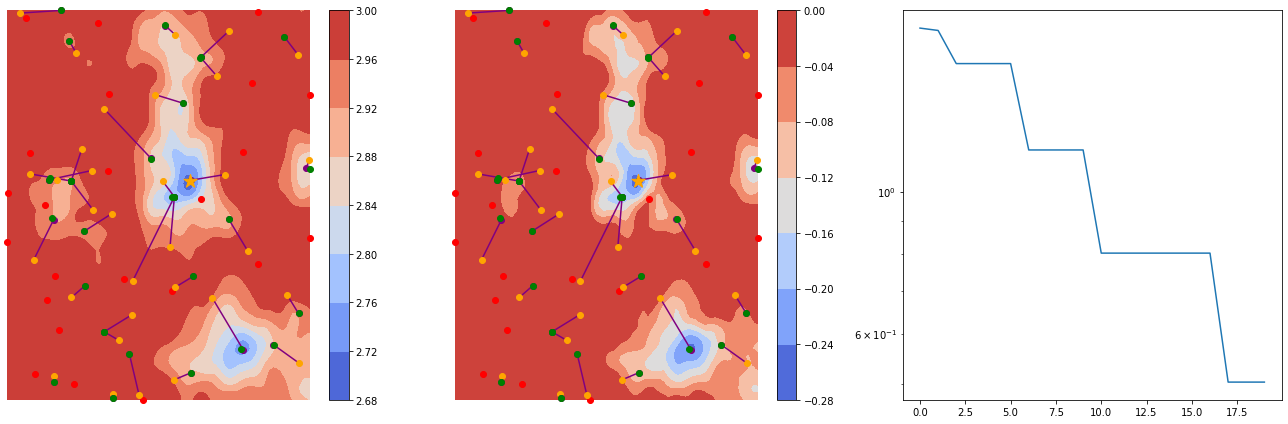

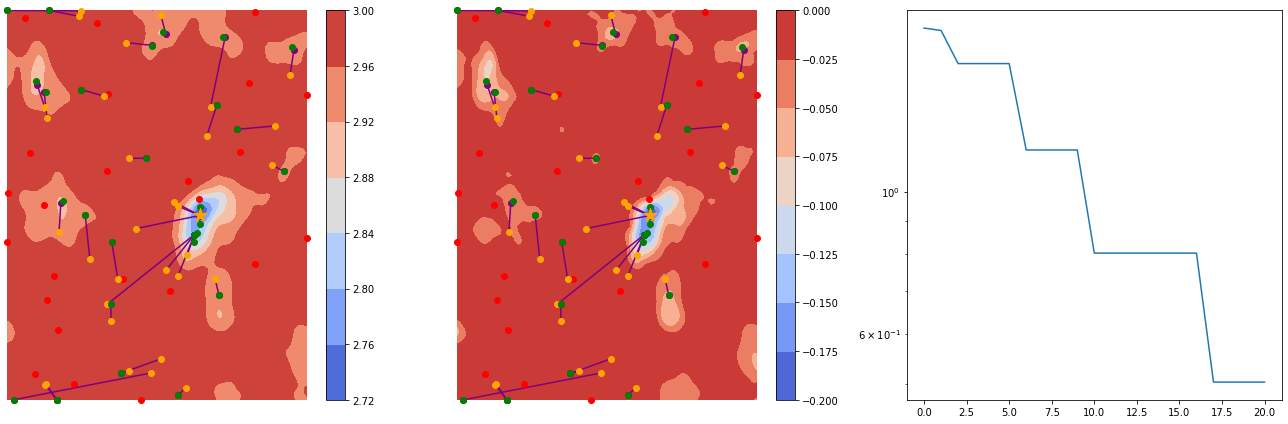

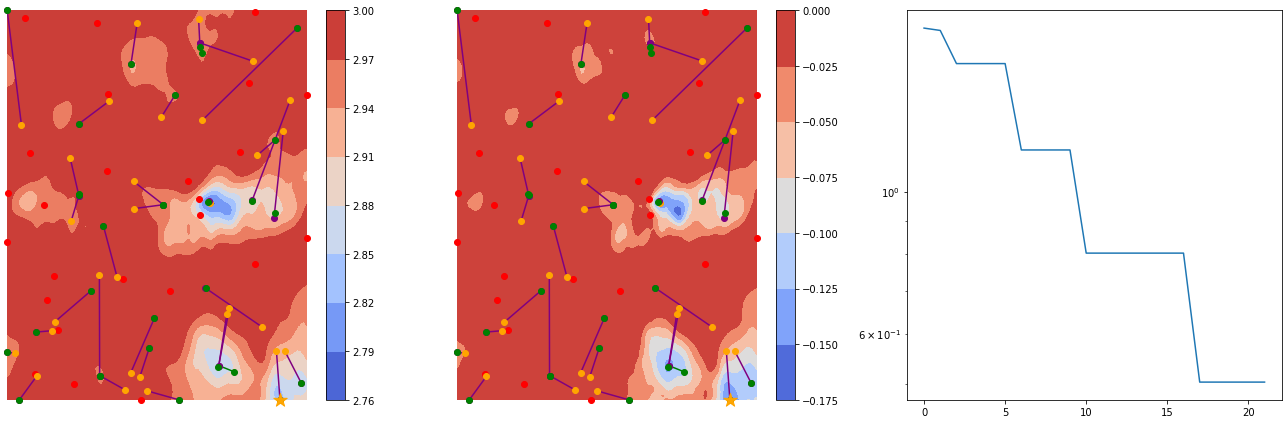

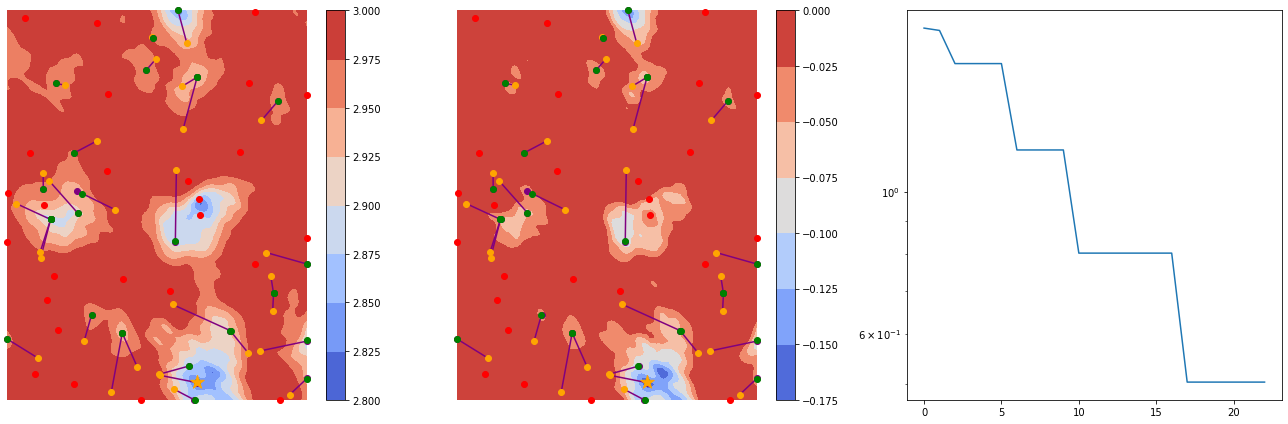

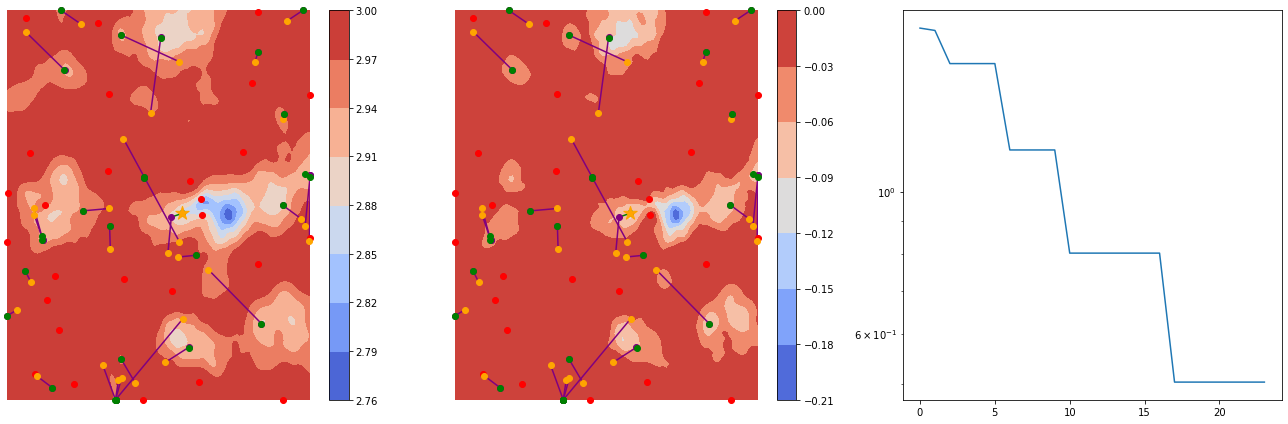

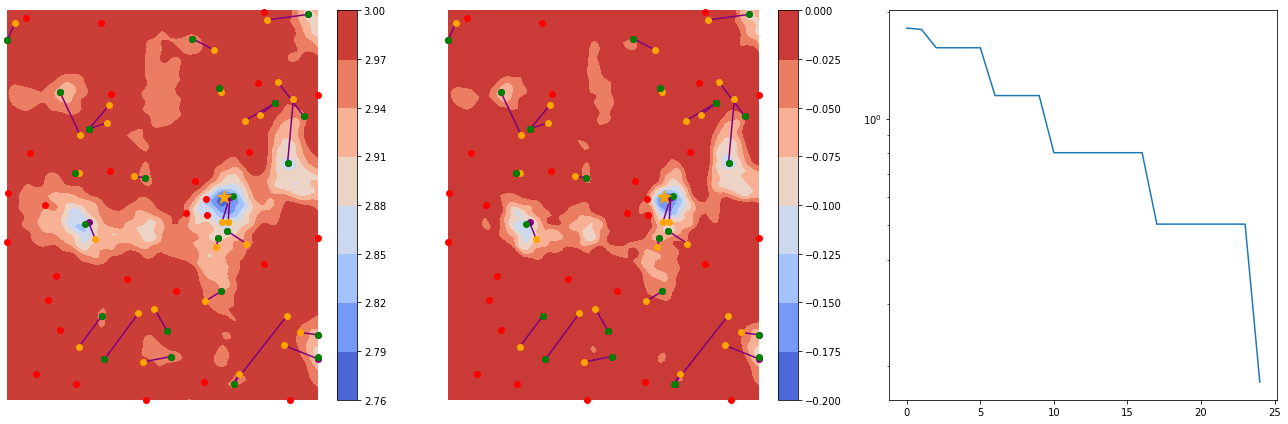

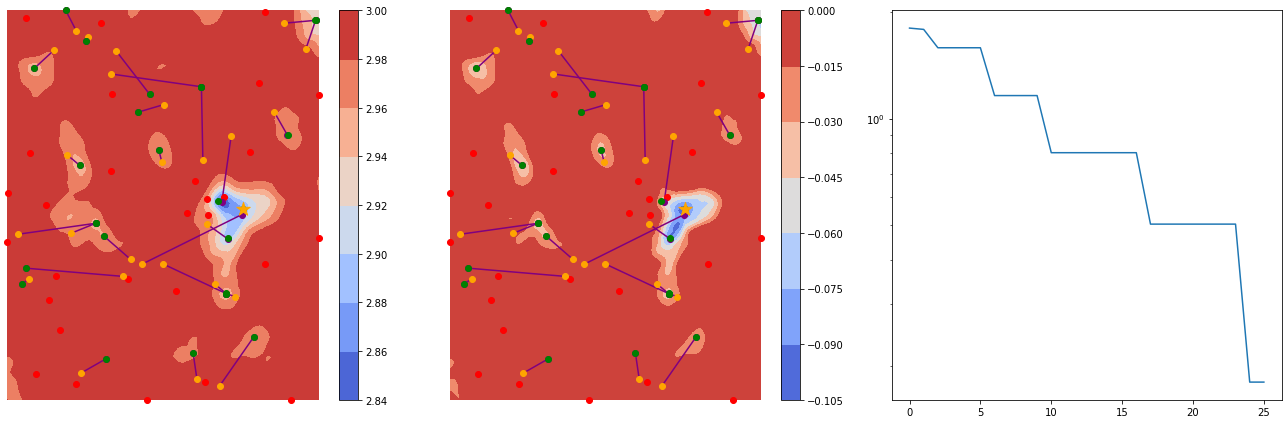

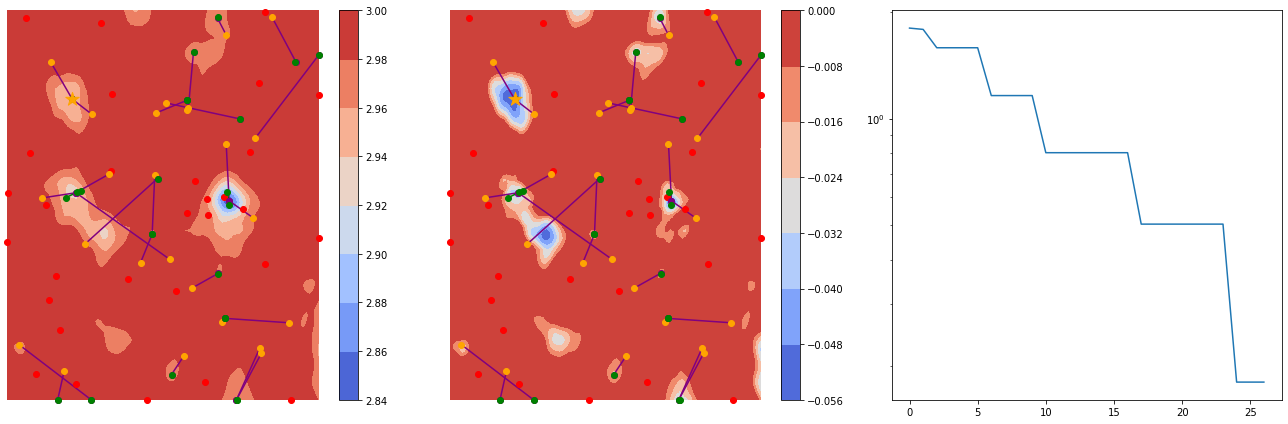

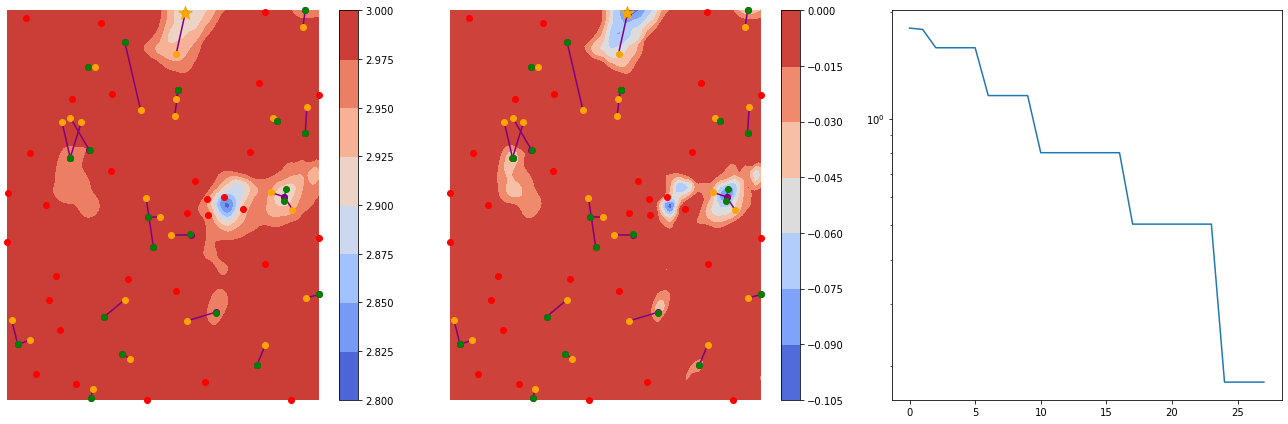

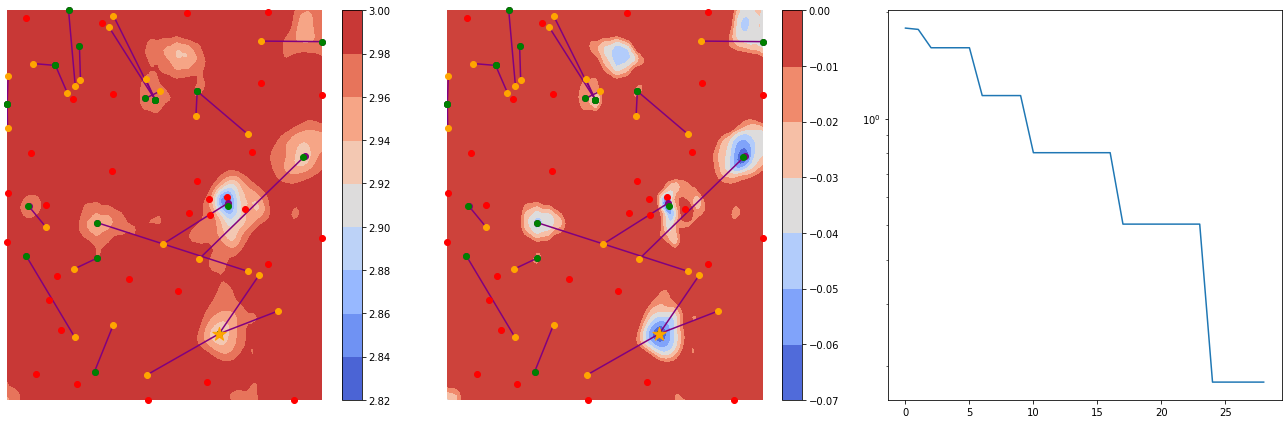

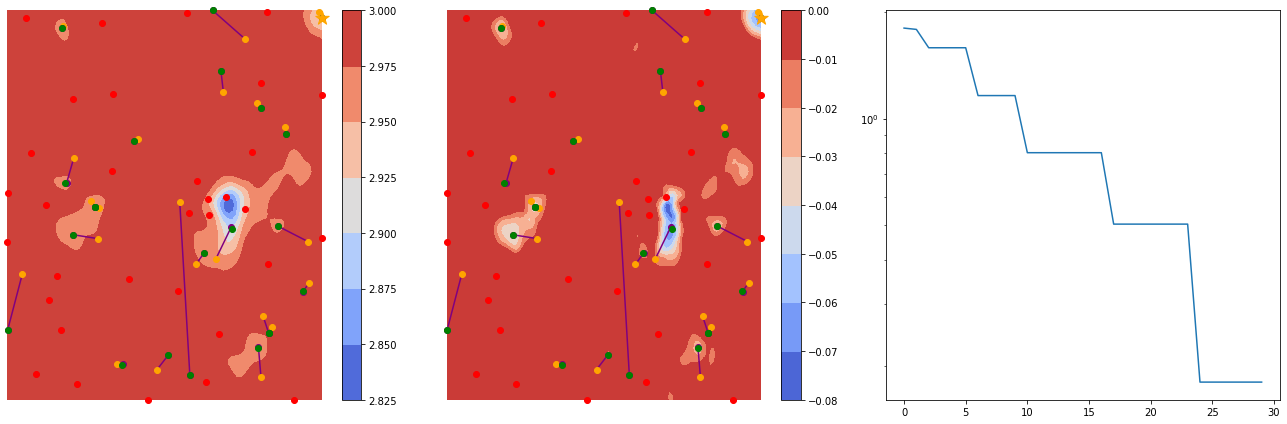

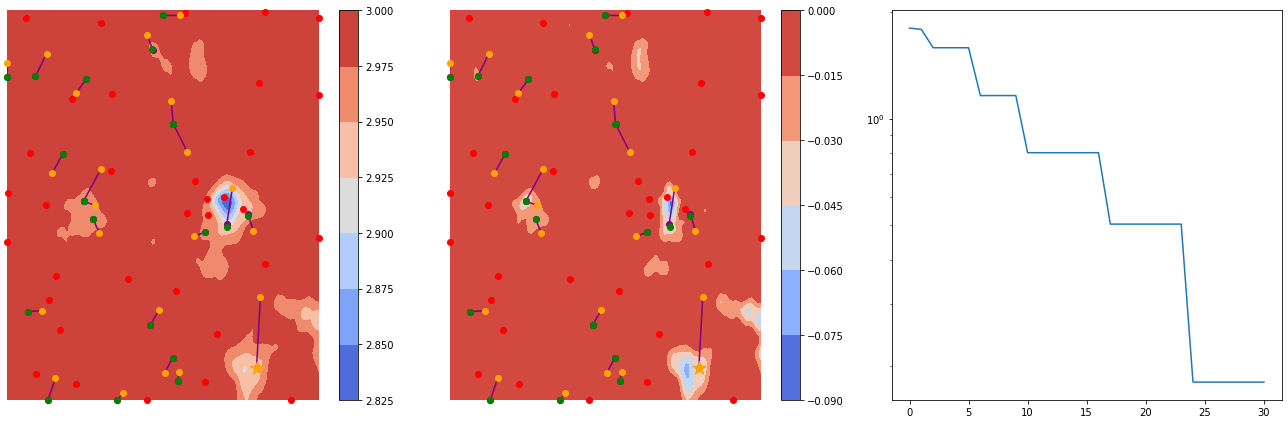

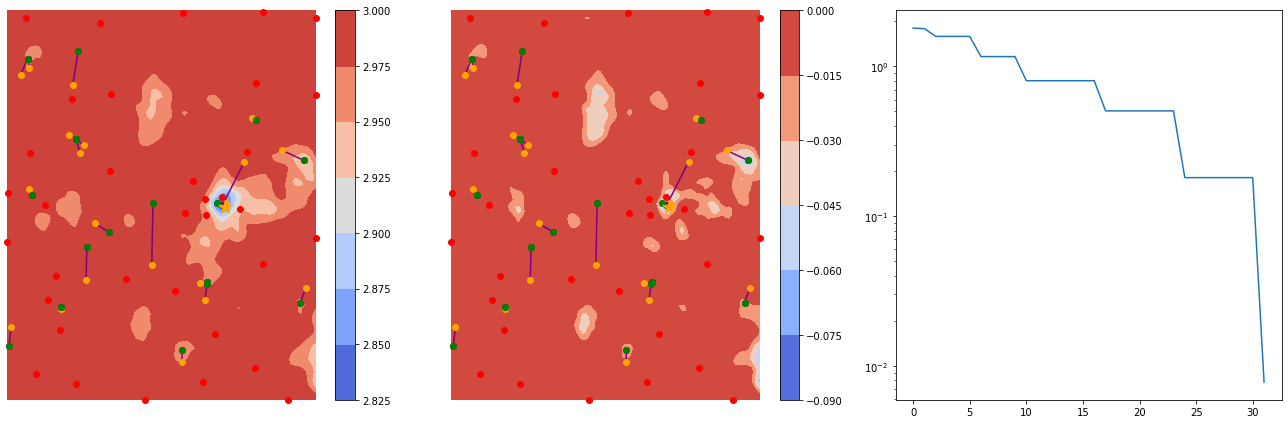

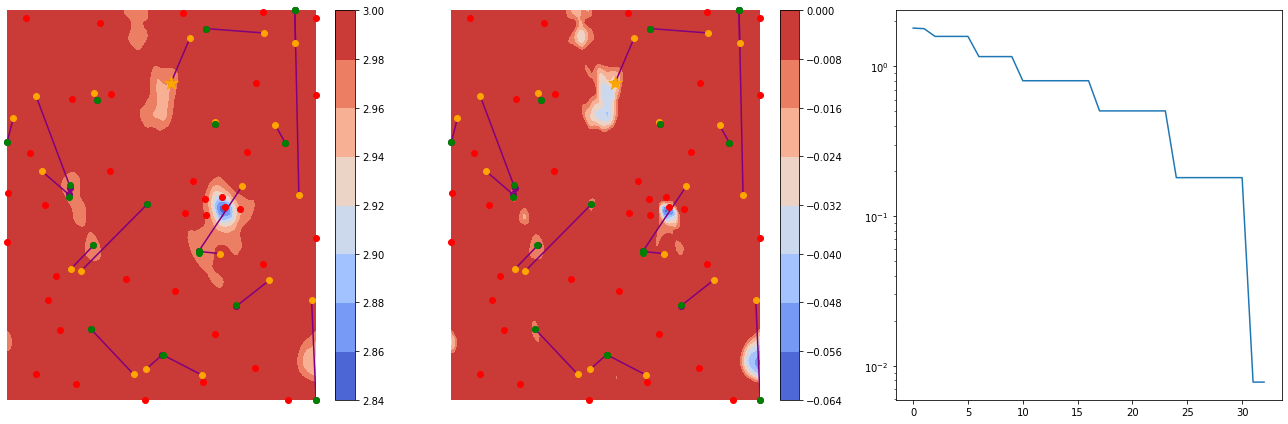

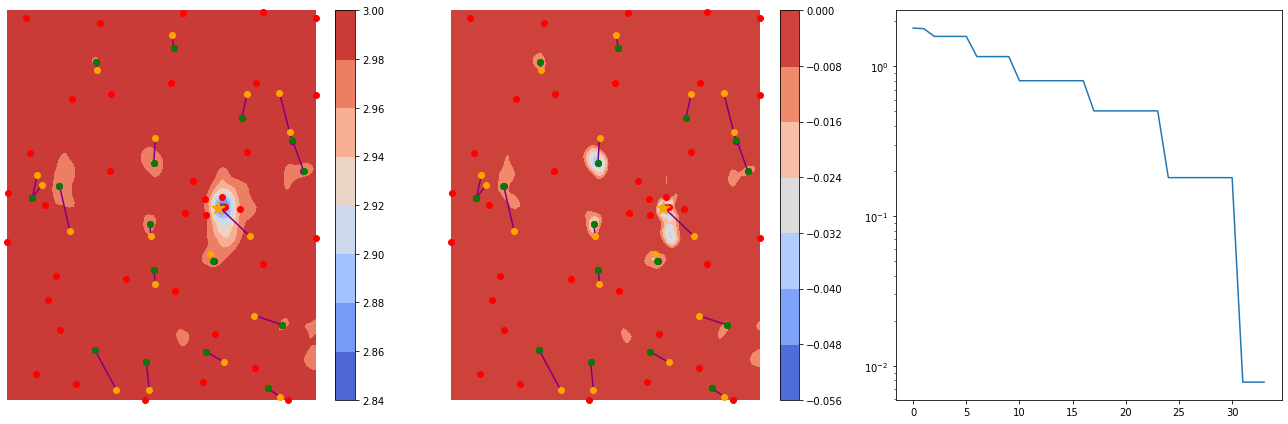

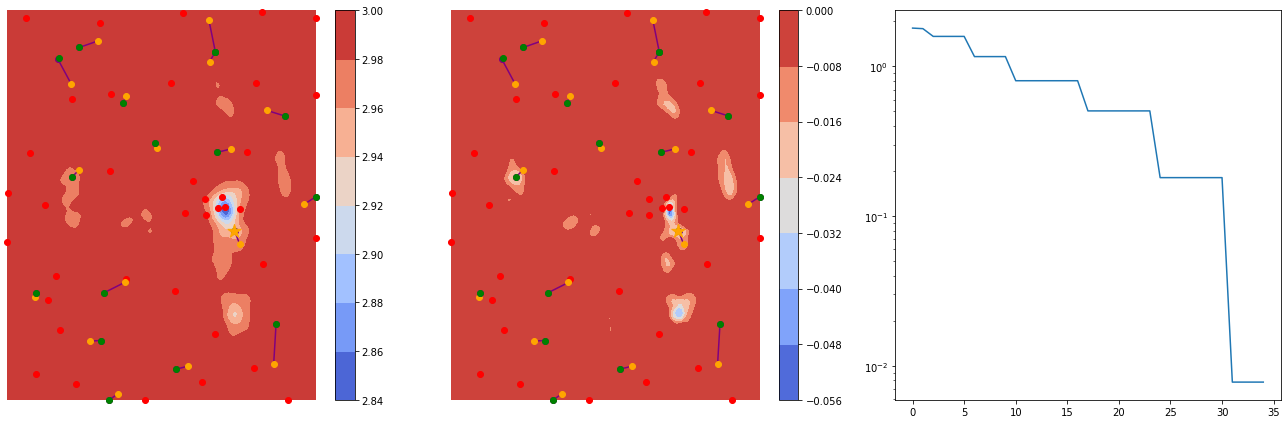

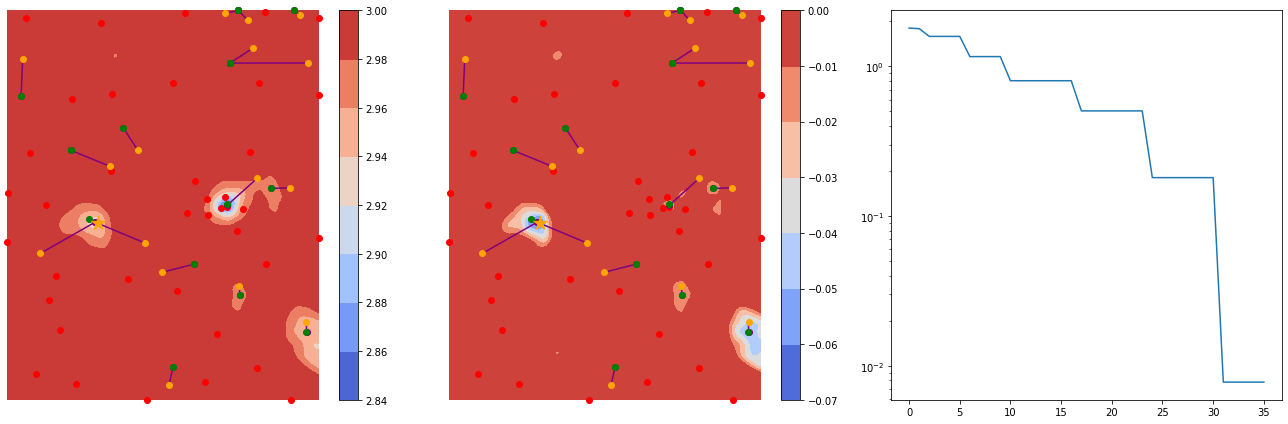

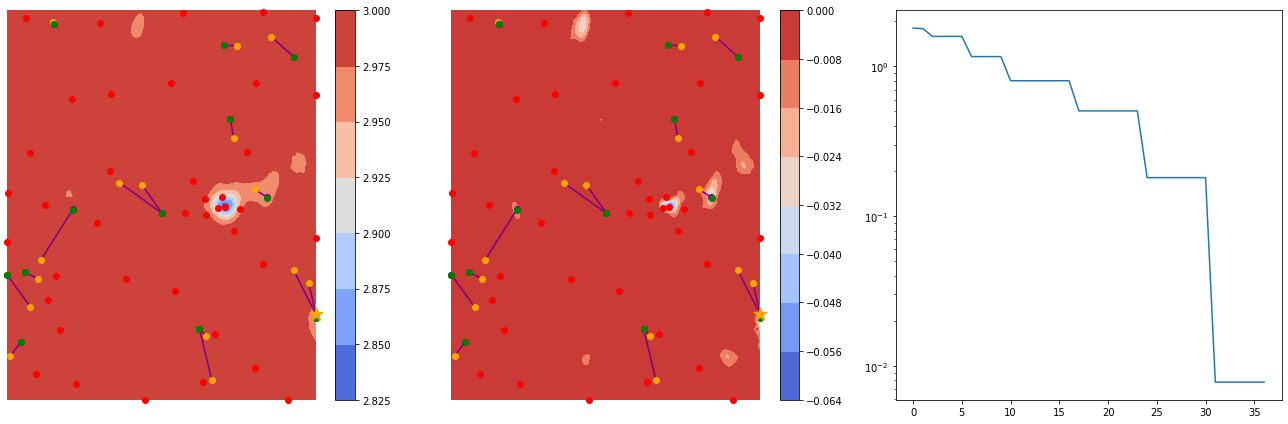

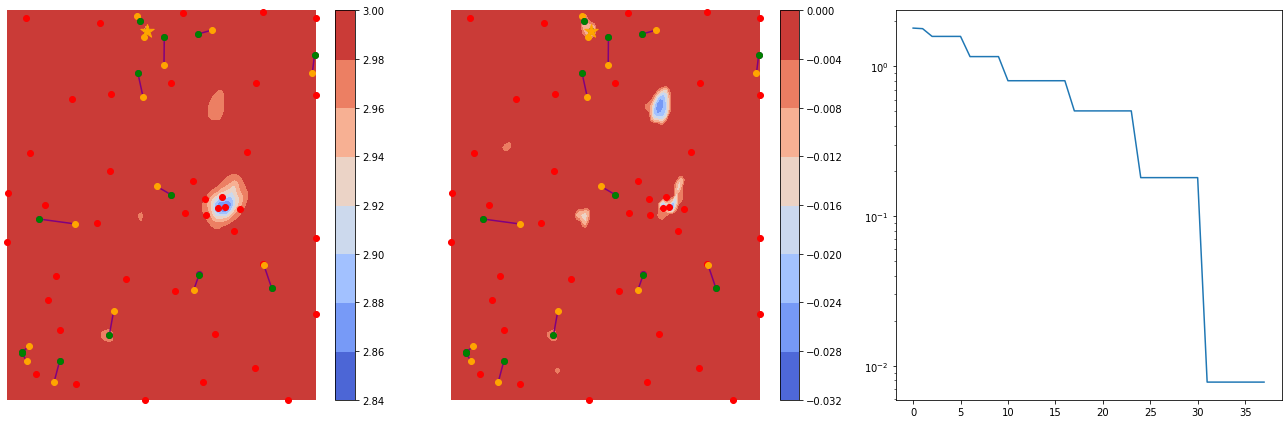

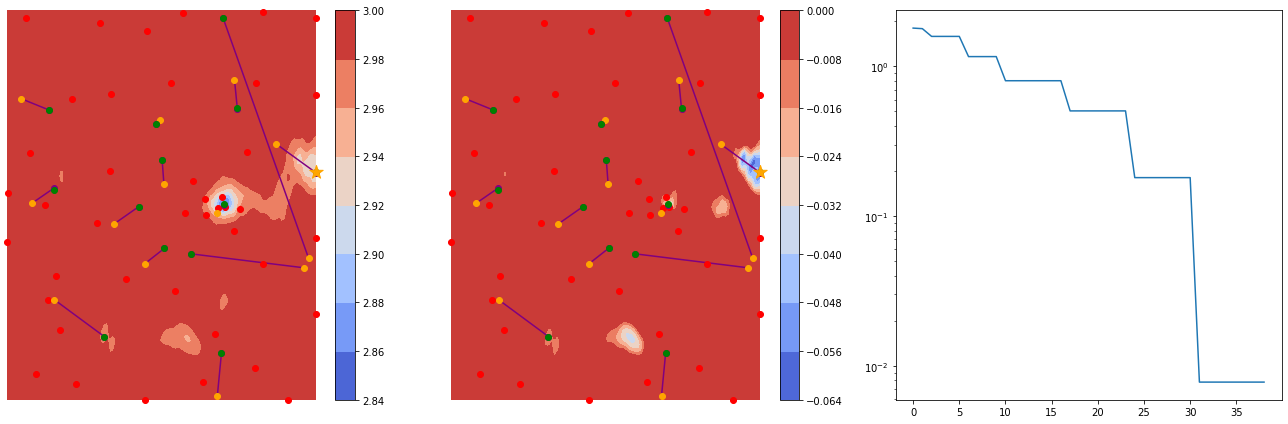

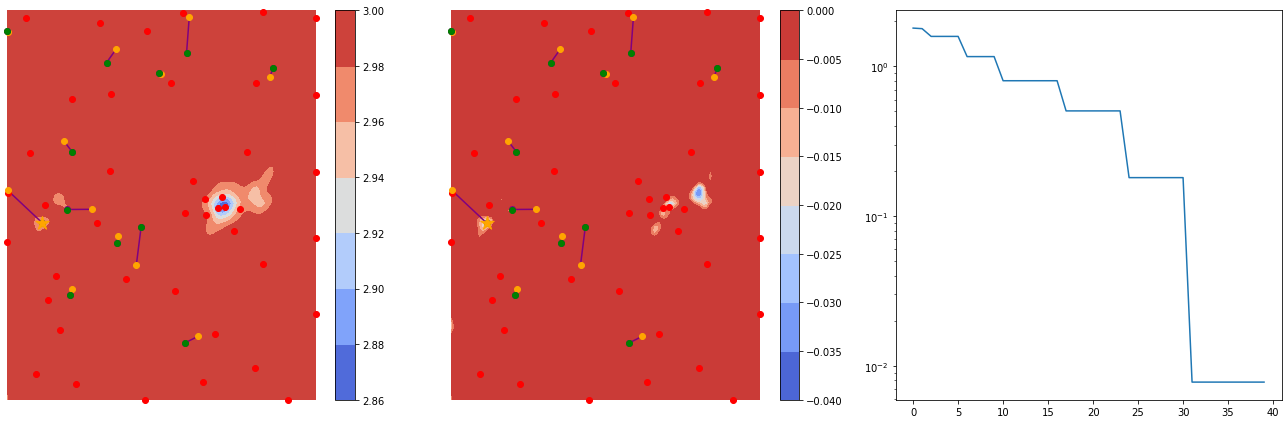

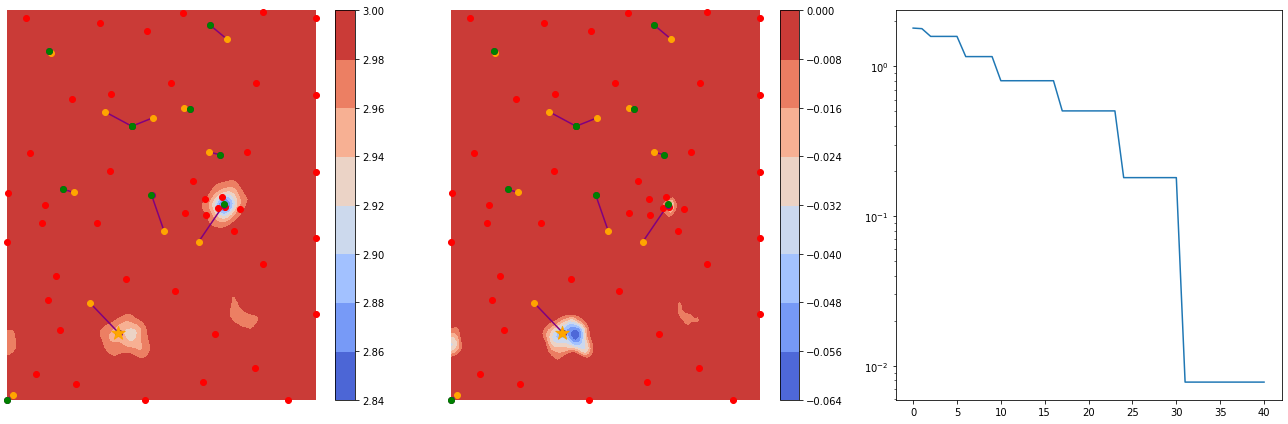

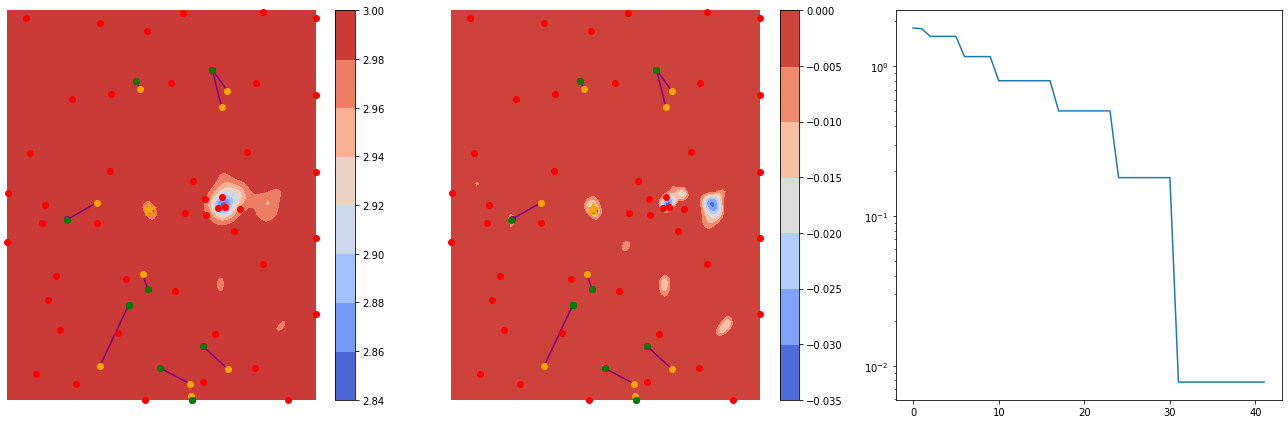

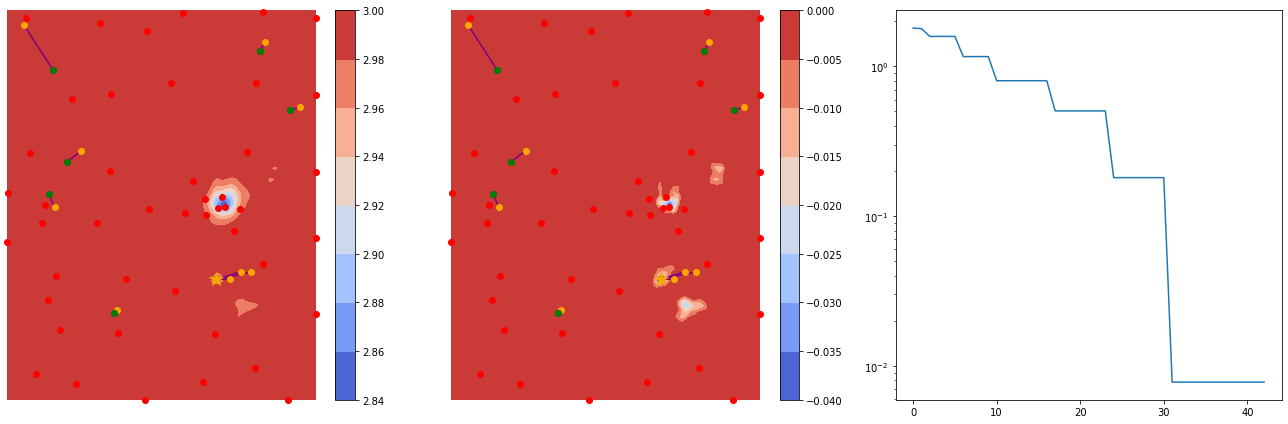

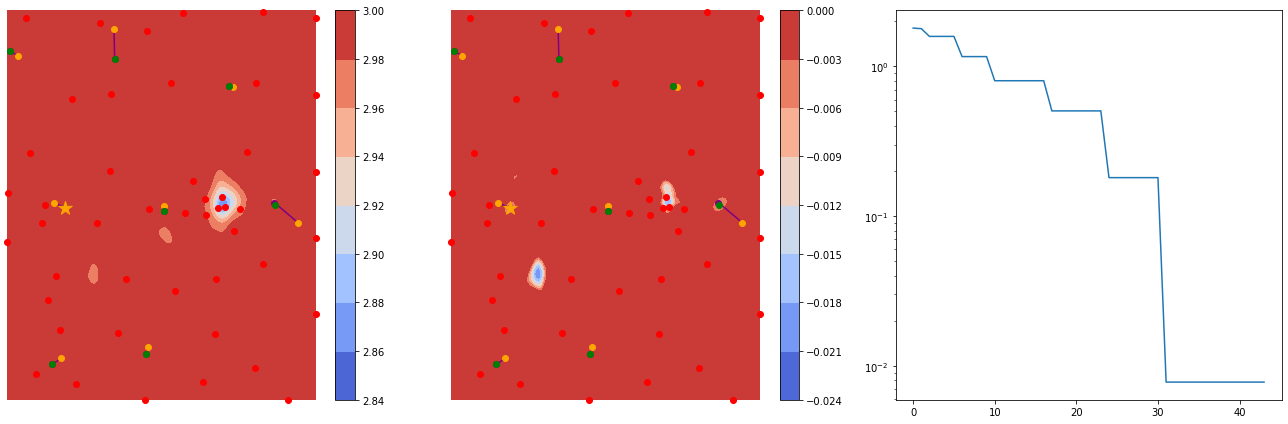

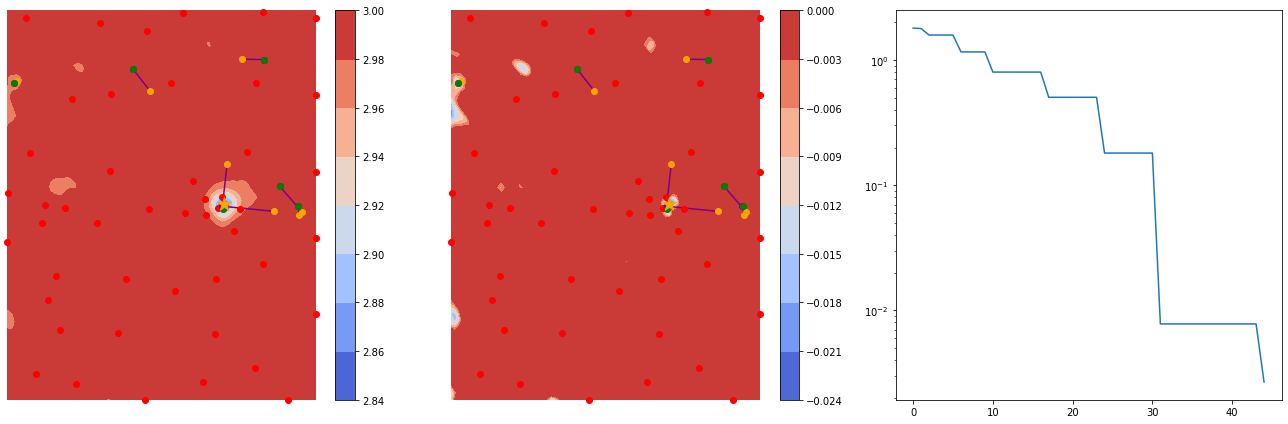

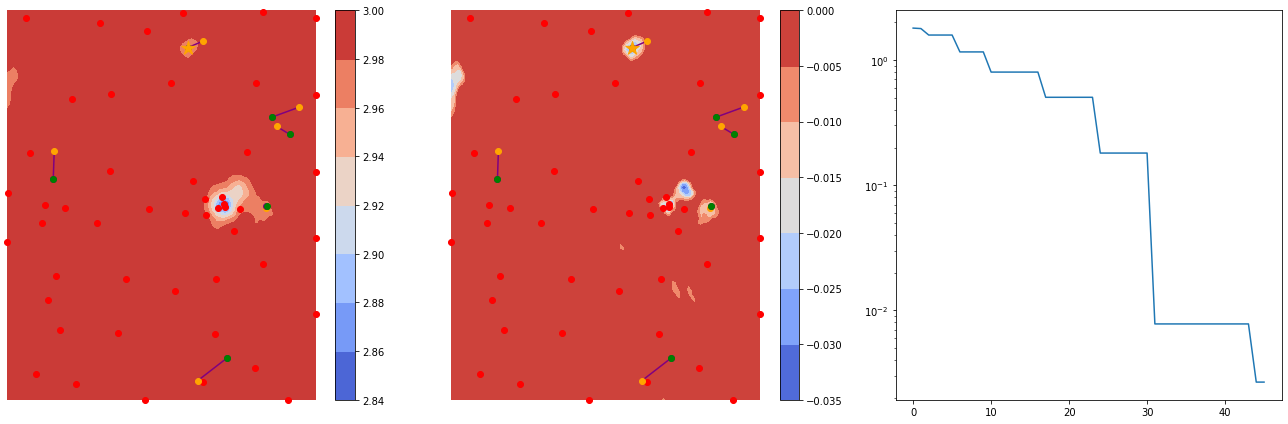

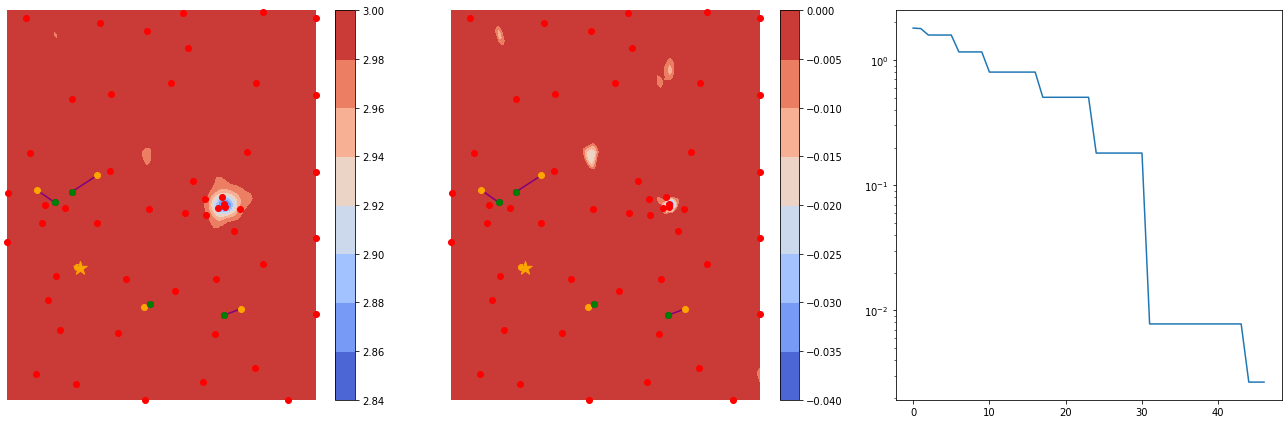

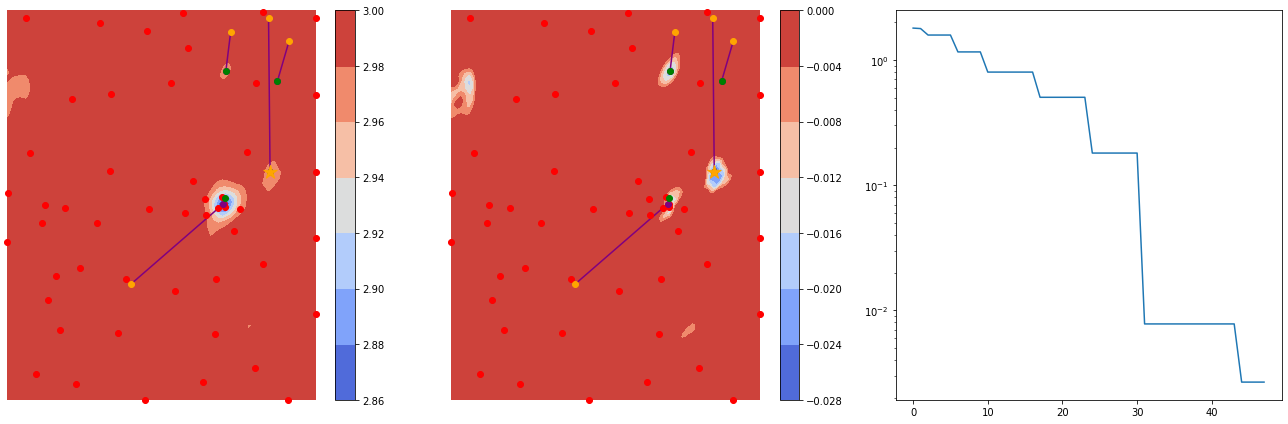

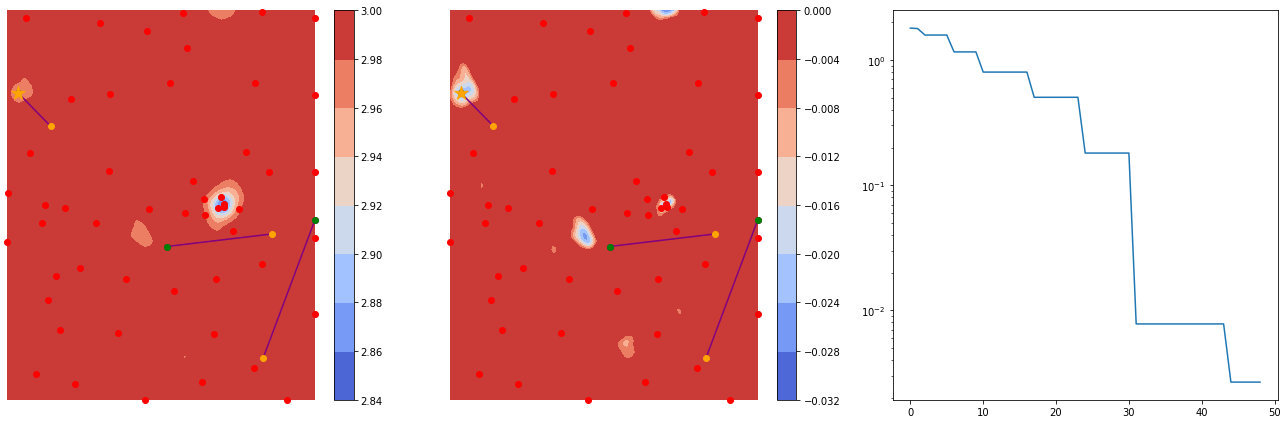

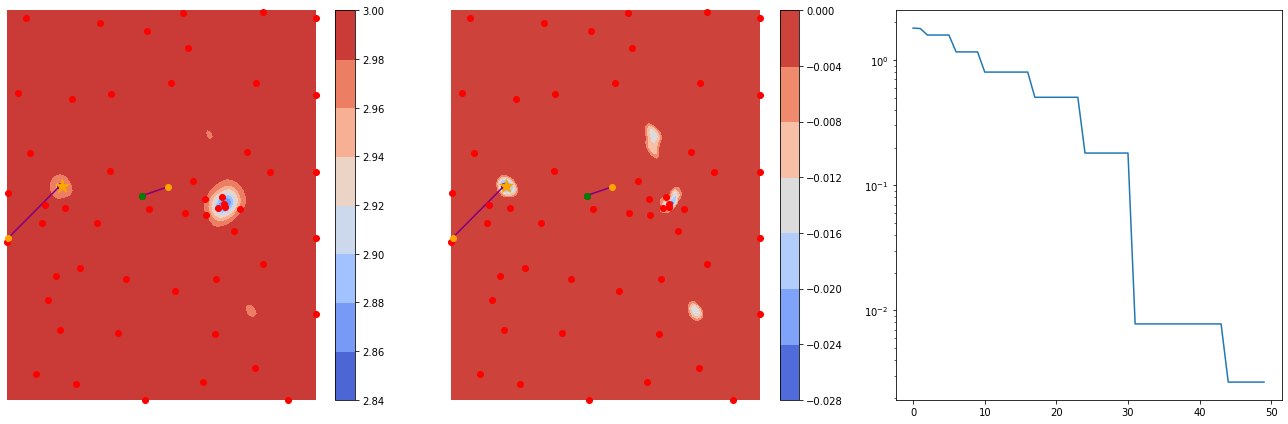

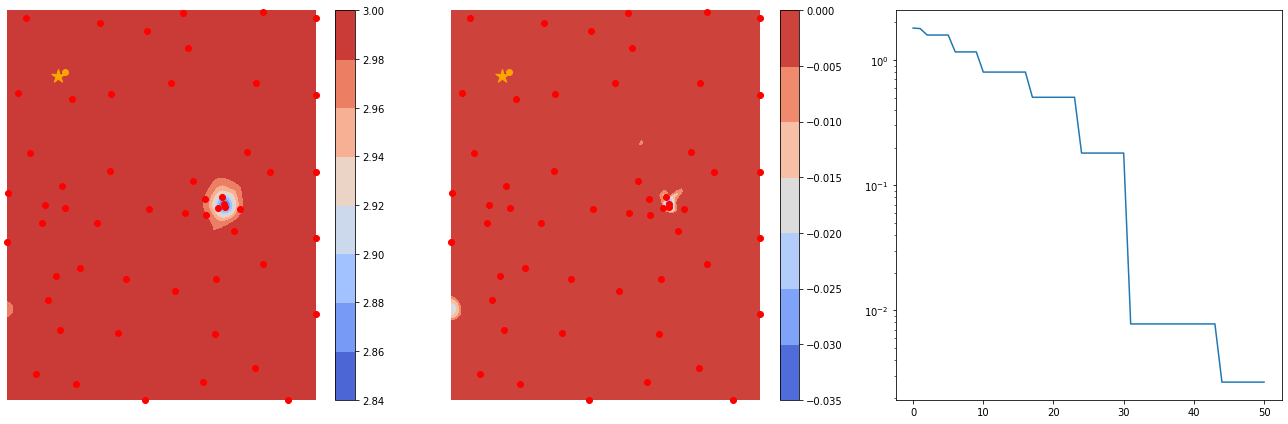

In [5]:
tf.random.set_seed(0)

objective = trieste.objectives.single_objectives.michalewicz_2 # scaled_branin
f = lambda x: tf.cast(objective(x), dtype=dtype)
num_queries = 50

x_min = tf.cast(MICHALEWICZ_2_SEARCH_SPACE.lower, dtype=dtype)
x_max = tf.cast(tf.convert_to_tensor(MICHALEWICZ_2_SEARCH_SPACE.upper), dtype=dtype)

x_plot = tf.meshgrid(tf.linspace(x_min[0], x_max[0], 100), tf.linspace(x_min[1], x_max[1], 100))
x_plot = tf.stack(x_plot, axis=-1)
x_plot = tf.cast(x_plot, dtype=dtype)

num_initial = 5
num_ei_samples = 20
num_bases = 2048
num_steps = 2000
learn_rate = 1e-3
mode = "best"
beta1 = 5.
beta2 = None
best_ys = []

x_data = tf.cast(
    tf.random.uniform([num_initial, 2]), 
    dtype=dtype
)

y_data = tf.cast(
    objective(x_data),
    dtype=dtype,
)

best_ys = best_ys + [float(tf.reduce_min(y_data))]

for i in range(num_queries):
    
    batch_size = num_queries - i
    
    # Set GP kernel and model
    kernel = gpflow.kernels.Matern32()
    
    gp = gpflow.models.GPR(
        data=(x_data, y_data),
        kernel=kernel,
        mean_function=None,
    )
    
    gp.kernel.lengthscales.assign(5e-1)
    gp.likelihood.variance.assign(1e-2)
    
    # Draw function samples from GP posterior
    prior_fn = priors.random_fourier(
        gp.kernel,
        sample_shape=[num_ei_samples],
        num_bases=num_bases,
    )
    
    function_samples = decoupled(
        gp.kernel,
        prior_fn,
        x_data,
        y_data,
        diag=gp.likelihood.variance.numpy(),
    )
    
    u = tf.random.uniform([batch_size, 2], dtype=dtype)
    initial_batch = u * x_min[None, :] + (1 - u) * x_max[None, :]

    threshold = tf.reduce_min(gp.predict_f(gp.data[0]))

    batch1, hist1 = compute_optimal_batch_lbfgsb(
        batch_x=initial_batch,
        threshold=threshold,
        x_min=x_min,
        x_max=x_max,
        num_points=batch_size,
        function_samples=function_samples,
        num_steps=num_steps,
        learn_rate=learn_rate,
        seed=i,
        beta=beta1,
    )

    batch2, hist2 = compute_optimal_batch_lbfgsb(
        threshold=threshold,
        x_min=x_min,
        x_max=x_max,
        num_points=batch_size,
        function_samples=function_samples,
        num_steps=num_steps,
        learn_rate=learn_rate,
        seed=i,
        beta=beta2,
        batch_x=batch1,
    )
    
    next_x, pointwise_ei = get_query_point(
        threshold=threshold,
        function_samples=function_samples,
        batch_x=batch2,
        mode=mode,
        temperature=None,
    )
    
    next_y = f(next_x[None, :])[0, :]
    best_ys.append(np.min([np.min(best_ys), float(next_y)]))
    
    plt.figure(figsize=(18, 6))
    
    marker_size = 100*tf.abs(pointwise_ei)/tf.reduce_max(tf.abs(pointwise_ei))
    
    pointwise_annealed_ei_plot = expected_improvement(
        function_samples=function_samples,
        batch_x=tf.reshape(x_plot, (-1, 2)),
        threshold=threshold,
        pointwise=True,
        beta=beta1,
    )
    
    pointwise_ei_plot = expected_improvement(
        function_samples=function_samples,
        batch_x=tf.reshape(x_plot, (-1, 2)),
        threshold=threshold,
        pointwise=True,
        beta=beta2,
    )
    
    pointwise_ei_plot = tf.reshape(pointwise_ei_plot, x_plot.shape[:2])
    pointwise_annealed_ei_plot = tf.reshape(pointwise_annealed_ei_plot, x_plot.shape[:2])
    
    plt.subplot(1, 3, 1)
    
    plt.scatter(x_data[:, 0], x_data[:, 1], color="red", clip_on=False, zorder=3)
    plt.scatter(initial_batch[:, 0], initial_batch[:, 1], color="orange", clip_on=False, zorder=3)
    plt.scatter(hist1[-1, :, 0], hist1[-1, :, 1], color="purple", clip_on=False, zorder=3)
    plt.scatter(hist2[-1, :, 0], hist2[-1, :, 1], color="green", clip_on=False, zorder=3)
    plt.scatter(next_x[0], next_x[1], color="orange", marker="*", s=200, clip_on=False, zorder=4)
    
    ax = plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], pointwise_annealed_ei_plot[:, :], cmap="coolwarm", alpha=1.0, zorder=1)
    plt.colorbar(ax)
    
    for j in range(batch_size):
        
        plt.plot([initial_batch[j, 0], batch1[j, 0]], [initial_batch[j, 1], batch1[j, 1]], color="purple")
        plt.plot([batch1[j, 0], batch2[j, 0]], [batch1[j, 1], batch2[j, 1]], color="green")
        
    plt.axis("off")
    
    
    plt.subplot(1, 3, 2)
    
    plt.scatter(x_data[:, 0], x_data[:, 1], color="red", clip_on=False, zorder=3)
    plt.scatter(initial_batch[:, 0], initial_batch[:, 1], color="orange", clip_on=False, zorder=3)
    plt.scatter(hist1[-1, :, 0], hist1[-1, :, 1], color="purple", clip_on=False, zorder=3)
    plt.scatter(hist2[-1, :, 0], hist2[-1, :, 1], color="green", clip_on=False, zorder=3)
    plt.scatter(next_x[0], next_x[1], color="orange", marker="*", s=200, clip_on=False, zorder=4)
    
    ax = plt.contourf(x_plot[:, :, 0], x_plot[:, :, 1], pointwise_ei_plot[:, :], cmap="coolwarm", alpha=1.0, zorder=1)
    plt.colorbar(ax)
    
    for j in range(batch_size):
        
        plt.plot([initial_batch[j, 0], batch1[j, 0]], [initial_batch[j, 1], batch1[j, 1]], color="purple")
        plt.plot([batch1[j, 0], batch2[j, 0]], [batch1[j, 1], batch2[j, 1]], color="green")
        
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.plot(best_ys-np.ones_like(np.array(best_ys))*MICHALEWICZ_2_MINIMUM)
    plt.yscale("log")
    
    plt.tight_layout()
    plt.show()
    
    x_data = tf.concat([x_data, next_x[None, :]], axis=0)
    y_data = tf.concat([y_data, next_y[None, :]], axis=0)